In [1]:
import numpy as np
from scipy.ndimage import convolve

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale


# 데이터셋을 변형하여 확장하는 함수: 원본 이미지를 상하좌우로 1픽셀씩 이동시킨다
def nudge_dataset(X, Y):
    """
    원본 데이터셋보다 5배 큰 데이터셋을 생성한다.
    X에 있는 8x8 이미지를 왼쪽, 오른쪽, 아래, 위로 1픽셀씩 이동시킨다.
    """
    direction_vectors = [
        [[0, 1, 0], [0, 0, 0], [0, 0, 0]],  # 왼쪽으로 이동
        [[0, 0, 0], [1, 0, 0], [0, 0, 0]],  # 오른쪽으로 이동
        [[0, 0, 0], [0, 0, 1], [0, 0, 0]],  # 아래로 이동
        [[0, 0, 0], [0, 0, 0], [0, 1, 0]],  # 위로 이동
    ]


    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode="constant", weights=w).ravel()

    X = np.concatenate(
        [X] + [np.apply_along_axis(shift, 1, X, vector) for vector in direction_vectors]
    )
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


# 손글씨 숫자 데이터셋을 로드한다
X, y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, "float32")
# 데이터셋을 확장한다
X, Y = nudge_dataset(X, y)
# 특성을 0과 1 사이로 스케일링한다
X = minmax_scale(X, feature_range=(0, 1))

# 데이터를 훈련 세트와 테스트 세트로 분할한다
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


In [2]:
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])

In [3]:
from sklearn.base import clone

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10

# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.57, time = 0.07s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.68, time = 0.19s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.74, time = 0.22s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.83, time = 0.17s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.62, time = 0.16s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -20.90, time = 0.17s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.92, time = 0.16s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.51, time = 0.16s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.31, time = 0.15s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.16, time = 0.14s


LogisticRegression(C=100.0, solver='newton-cg', tol=1)

In [4]:
from sklearn import metrics

Y_pred = rbm_features_classifier.predict(X_test)
print(
    "Logistic regression using RBM features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.91      0.93      0.92       184
           2       0.94      0.96      0.95       166
           3       0.95      0.87      0.91       194
           4       0.96      0.95      0.95       186
           5       0.92      0.92      0.92       181
           6       0.98      0.98      0.98       207
           7       0.93      0.99      0.96       154
           8       0.90      0.87      0.89       182
           9       0.88      0.91      0.89       169

    accuracy                           0.93      1797
   macro avg       0.93      0.94      0.93      1797
weighted avg       0.94      0.93      0.93      1797




In [5]:
Y_pred = raw_pixel_classifier.predict(X_test)
print(
    "Logistic regression using raw pixel features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       174
           1       0.60      0.58      0.59       184
           2       0.75      0.85      0.80       166
           3       0.78      0.78      0.78       194
           4       0.81      0.84      0.83       186
           5       0.77      0.76      0.76       181
           6       0.90      0.87      0.89       207
           7       0.86      0.88      0.87       154
           8       0.67      0.58      0.62       182
           9       0.75      0.76      0.75       169

    accuracy                           0.78      1797
   macro avg       0.78      0.78      0.78      1797
weighted avg       0.78      0.78      0.78      1797




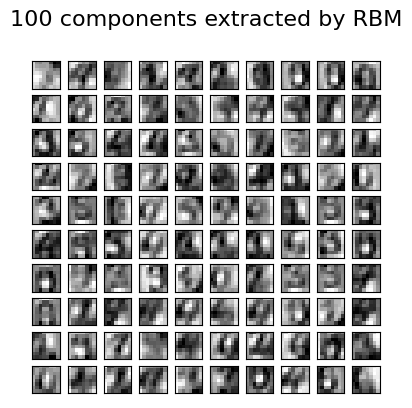

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("100 components extracted by RBM", fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()